In [25]:
library(dplyr)
library(readr)
library(tidyr)
library(forcats)
library(janitor)
library(ggplot2)
library(scales)

In [35]:
# Path
path <- "../"

# Read the data
df <- read_csv(paste0(path, "output/ZX05/CF costs.csv"), show_col_types = FALSE) %>%
  clean_names()


# Change data type
df <- df %>%
  mutate(across(cost_ctr, as.character))

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


In [27]:
# Filter primary costs
df <- df %>%
  filter(acc_lv2 %in% c(
    "299 Total Labor Costs",
    "465 Cost of materials",
    "535 Services In/Out"
  ))


# Select columns
id_cols <- c(
  "fy",
  "period",
  "cost_ctr",
  "gl_accounts",
  "profit_ctr",
  "fix_var",
  "department",
  "acc_lv2"
)
numeric_cols <- c(
  "plan",
  "actual",
  # "target",
  "delta_to_plan"
)

df <- df %>%
  select(all_of(id_cols), all_of(numeric_cols))


# Change sign logic from RACE to SAP & from k LC to LC
df <- df %>%
  mutate(
    across(numeric_cols, ~ (.x * -1e+3)),
    across(c("delta_to_plan"), ~ (.x * -1))
  )

In [28]:
head(df)

fy,period,cost_ctr,gl_accounts,profit_ctr,fix_var,department,acc_lv2,plan,actual,delta_to_plan
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2023,1,4110,K30001,50899-999,Fix,Purchasing,299 Total Labor Costs,15870312,12296700,3573612
2023,1,4110,K301,50899-999,Fix,Purchasing,299 Total Labor Costs,0,293800,-293800
2023,1,4110,K359,50899-999,Fix,Purchasing,299 Total Labor Costs,189573,200000,-10427
2023,1,4110,K4431,50899-999,Fix,Purchasing,465 Cost of materials,95949,11996,83953
2023,1,4110,K4490,50899-999,Fix,Purchasing,465 Cost of materials,30150,30150,0
2023,1,4110,K4500,50899-999,Fix,Purchasing,465 Cost of materials,49843,2783,47060


## Delta charts

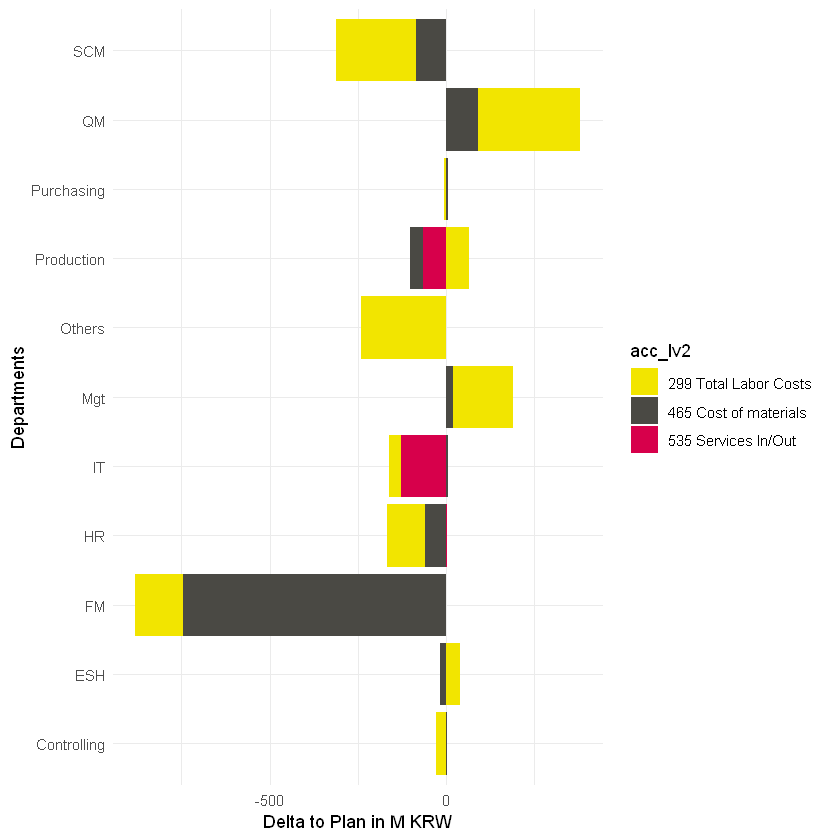

In [29]:
ggplot(
    df,
    aes(
        x = delta_to_plan,
        y = department,  # fct_reorder(department, desc(delta_to_plan)),
        fill = acc_lv2
    )
) + 
    geom_bar(stat = "summary", fun = "sum", position = "stack") +
    scale_x_continuous(labels = label_number(scale = 1 / 1e+6)) +
    scale_fill_manual(values = c("#F2E500", "#4A4944", "#D7004B")) +
    labs(x = "Delta to Plan in M KRW", y = "Departments") +
    theme_minimal()

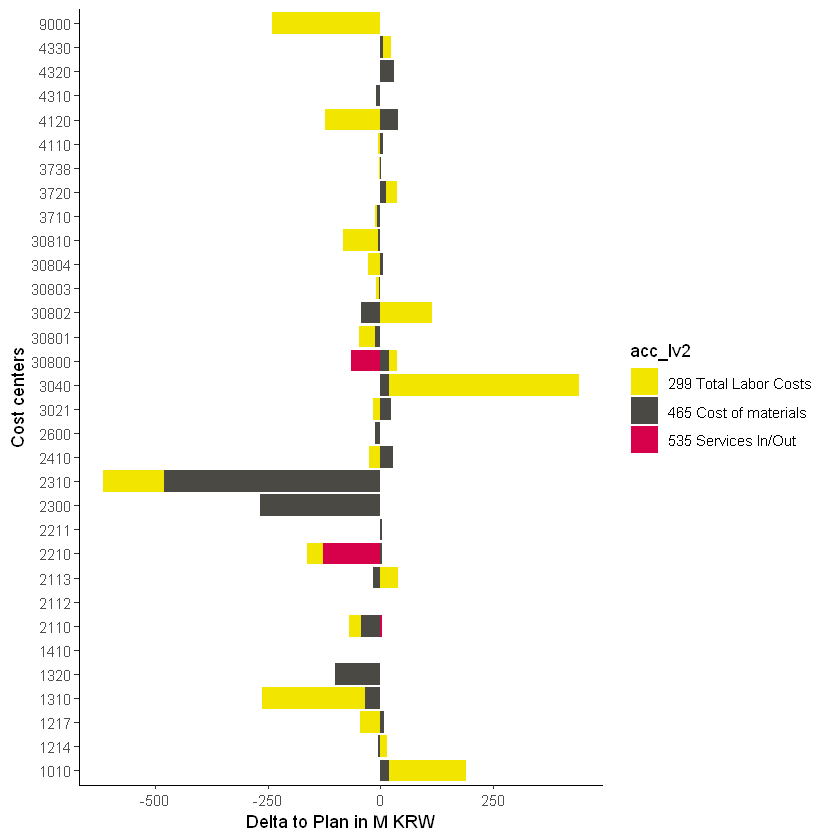

In [30]:
ggplot(
    df,
    aes(
        x = delta_to_plan,
        y = cost_ctr,
        fill = acc_lv2
    )
) + 
    geom_bar(stat = "summary", fun = "sum", position = "stack") +
    scale_x_continuous(labels = label_number(scale = 1 / 1e+6)) +
    scale_fill_manual(values = c("#F2E500", "#4A4944", "#D7004B")) +
    labs(x = "Delta to Plan in M KRW", y = "Cost centers") +
    theme_classic()

In [31]:
# Summarize the data ----
df <- df %>%
  group_by(pick(id_cols)) %>%
  summarise(across(numeric_cols, sum)) %>%
  ungroup()

top_10_negative <- df %>%
  arrange(delta_to_plan) %>%
  slice_head(n = 10)

top_10_positive <- df %>%
  arrange(delta_to_plan) %>%
  slice_tail(n = 10)

df_sum <- df %>%
  group_by() %>%
  summarise(across(numeric_cols, sum)) %>%
  ungroup()

Warning message:
"There was 1 warning in `group_by()`.
ℹ In argument: `pick(id_cols)`.
Caused by warning:
! Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(id_cols)

  # Now:
  data %>% select(all_of(id_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."
`summarise()` has grouped output by 'fy', 'period', 'cost_ctr', 'gl_accounts',
'profit_ctr', 'fix_var', 'department'. You can override using the `.groups`
argument.


## Data tables

In [32]:
top_10_negative

fy,period,cost_ctr,gl_accounts,profit_ctr,fix_var,department,acc_lv2,plan,actual,delta_to_plan
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2023,3,9000,K32101,50899-999,Fix,Others,299 Total Labor Costs,0,240989348,-240989348
2023,6,2310,K491,50899-999,Fix,FM,465 Cost of materials,76666667,223871174,-147204507
2023,3,2300,K45001,50899-999,Fix,FM,465 Cost of materials,0,140500000,-140500000
2023,3,2310,K491,50899-999,Fix,FM,465 Cost of materials,76666667,205835800,-129169133
2023,6,30801,K30001,50899-999,Fix,Production,299 Total Labor Costs,126969837,248126600,-121156763
2023,3,2300,K4653,50899-999,Fix,FM,465 Cost of materials,0,113513280,-113513280
2023,6,2300,K45001,50899-999,Fix,FM,465 Cost of materials,0,105560718,-105560718
2023,2,2300,K45001,50899-999,Fix,FM,465 Cost of materials,0,92800000,-92800000
2023,6,2300,K491,50899-999,Fix,FM,465 Cost of materials,0,89700000,-89700000


In [33]:
top_10_positive

fy,period,cost_ctr,gl_accounts,profit_ctr,fix_var,department,acc_lv2,plan,actual,delta_to_plan
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2023,6,3040,K30001,50899-999,Fix,QM,299 Total Labor Costs,49140766,-3893500,53034266
2023,4,3040,K30001,50899-999,Fix,QM,299 Total Labor Costs,47328846,-7441100,54769946
2023,1,2113,K5401,50899-999,Fix,ESH,465 Cost of materials,61477833,0,61477833
2023,6,30801,K202,50899-999,Fix,Production,299 Total Labor Costs,0,-61964700,61964700
2023,1,2300,K4500,50899-999,Fix,FM,465 Cost of materials,64844667,0,64844667
2023,2,2300,K4500,50899-999,Fix,FM,465 Cost of materials,64844667,0,64844667
2023,3,2300,K4500,50899-999,Fix,FM,465 Cost of materials,64844667,0,64844667
2023,4,2300,K4500,50899-999,Fix,FM,465 Cost of materials,64844667,0,64844667
2023,5,2300,K4500,50899-999,Fix,FM,465 Cost of materials,64844667,0,64844667


In [34]:
bind_rows(df, df_sum)


fy,period,cost_ctr,gl_accounts,profit_ctr,fix_var,department,acc_lv2,plan,actual,delta_to_plan
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2023,1,1010,K30001,50899-999,Fix,Mgt,299 Total Labor Costs,66649587,51617300,15032287
2023,1,1010,K4224,50899-999,Fix,Mgt,465 Cost of materials,3861000,3789181,71819
2023,1,1010,K44199,50899-999,Fix,Mgt,465 Cost of materials,0,-3861000,3861000
2023,1,1010,K4431,50899-999,Fix,Mgt,465 Cost of materials,127932,23991,103941
2023,1,1010,K4461,50899-999,Fix,Mgt,465 Cost of materials,0,3861000,-3861000
2023,1,1010,K4490,50899-999,Fix,Mgt,465 Cost of materials,0,100481,-100481
2023,1,1010,K4500,50899-999,Fix,Mgt,465 Cost of materials,130457,29356,101101
2023,1,1010,K4611,50899-999,Fix,Mgt,465 Cost of materials,233934,316629,-82695
2023,1,1010,K4706,50899-999,Fix,Mgt,299 Total Labor Costs,5355000,5172180,182820
